In [1]:
!rm -rf linkedin-job-trends  # optional: clean old repo
!git clone https://github.com/krishang-parakh/linkedin-job-trends.git

Cloning into 'linkedin-job-trends'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 40 (delta 8), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (40/40), 6.55 MiB | 4.19 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [2]:
!pip install pyspark
!pip install graphframes
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("LinkedIn Job Postings").master("local[*]").config("spark.jars.packages", "graphframes:graphframes:0.8.1-spark3.0-s_2.12").getOrCreate()
from pyspark.ml.feature import Imputer

In [3]:
file_paths = {
    "benefits": "linkedin-job-trends/data/benefits.csv",
    "companies": "linkedin-job-trends/data/companies.csv",
    "company_industries": "linkedin-job-trends/data/company_industries.csv",
    "company_specialities": "linkedin-job-trends/data/company_specialities.csv",
    "employee_counts": "linkedin-job-trends/data/employee_counts.csv",
    "industries": "linkedin-job-trends/data/industries.csv",
    "job_industries": "linkedin-job-trends/data/job_industries.csv",
    "job_postings": "linkedin-job-trends/data/job_postings.csv",
    "job_skills": "linkedin-job-trends/data/job_skills.csv",
    "salaries": "linkedin-job-trends/data/salaries.csv",
    "skills": "linkedin-job-trends/data/skills.csv",
}

In [4]:
import os

for key, path in file_paths.items():
    print(f"{key:20} ➜ {'✅ Found' if os.path.exists(path) else '❌ Not Found'}")

benefits             ➜ ✅ Found
companies            ➜ ✅ Found
company_industries   ➜ ✅ Found
company_specialities ➜ ✅ Found
employee_counts      ➜ ✅ Found
industries           ➜ ✅ Found
job_industries       ➜ ✅ Found
job_postings         ➜ ✅ Found
job_skills           ➜ ✅ Found
salaries             ➜ ✅ Found
skills               ➜ ✅ Found


In [5]:
# Assuming simplified schema for demonstration, adjust according to your CSV files
job_postings_schema = "job_id STRING, title STRING, description STRING, location STRING, company_id STRING"
job_industries_schema = "job_id STRING, industry_id STRING"
job_skills_schema = "job_id STRING, skill_abr STRING"
industries_schema = "industry_id STRING, industry_name STRING"
skills_schema = "skill_abr STRING, skill_name STRING"
salaries_schema = "job_id STRING, salary INT, currency STRING"
employee_counts_schema = "company_id STRING, employee_count INT"

# Read CSV files into DataFrames, assuming header=True and inferring schema for demonstration
job_postings_df = spark.read.option("header", "true").csv(file_paths["job_postings"])
job_industries_df = spark.read.option("header", "true").csv(file_paths["job_industries"])
job_skills_df = spark.read.option("header", "true").csv(file_paths["job_skills"])
industries_df = spark.read.option("header", "true").csv(file_paths["industries"])
skills_df = spark.read.option("header", "true").csv(file_paths["skills"])

# Perform joins
joined_df = job_postings_df \
    .join(job_industries_df, on="job_id", how="inner") \
    .join(industries_df, on="industry_id", how="inner") \
    .join(job_skills_df, on="job_id", how="inner") \
    .join(skills_df, on="skill_abr", how="inner")

In [6]:
import shutil
import time

streaming_directory = "stream_simulation/"
streaming_checkpoint_directory = "stream_checkpoint/"

# Convert the DataFrame to JSON and save it to simulate the initial load
joined_df.write.mode("overwrite").json(streaming_directory)

# Assuming the schema of joined_df is correctly defined and does not include duplicate columns
stream_df = spark.readStream.schema(joined_df.schema).json(streaming_directory)

# Start the streaming query to output to a memory table
query = stream_df.writeStream.queryName("streaming_data").format("memory").outputMode("update").start()

# Function to perform SQL queries and display results
def display_streaming_data():
    # Display top industries by job postings
    print("Job Postings by Industry:\n")
    spark.sql("""
        SELECT industry_name, COUNT(*) AS job_count
        FROM streaming_data
        GROUP BY industry_name
        ORDER BY job_count DESC
    """).show(truncate=False)

    # Display top skills by job postings
    print("Job Availability by Skill Type:\n")
    spark.sql("""
        SELECT skill_name, COUNT(*) AS job_count
        FROM streaming_data
        GROUP BY skill_name
        ORDER BY job_count DESC
    """).show(truncate=False)

    # Select skill names along with the list of industries that require them
    print("List of Industries by Skills Required:\n")
    spark.sql("""
        SELECT skill_name, collect_set(industry_name) AS industries
        FROM streaming_data
        GROUP BY skill_name
    """).show(truncate=False)

# Simulate streaming by appending new data
for i in range(1, 16):
    print(f"Iteration: {i}")
    # Specify the source file for the initial data
    source_file = streaming_directory + "part-00000"  # This assumes only one part file exists; adjust as necessary
    destination_file = streaming_directory + f"data_{i}.json"

    time.sleep(5)  # Adjust based on your system
    display_streaming_data()

# Stop the query
query.stop()

Iteration: 1
Job Postings by Industry:

+-------------+---------+
|industry_name|job_count|
+-------------+---------+
+-------------+---------+

Job Availability by Skill Type:

+----------+---------+
|skill_name|job_count|
+----------+---------+
+----------+---------+

List of Industries by Skills Required:

+----------+----------+
|skill_name|industries|
+----------+----------+
+----------+----------+

Iteration: 2
Job Postings by Industry:

+-----------------------------------------------------+---------+
|industry_name                                        |job_count|
+-----------------------------------------------------+---------+
|IT Services and IT Consulting                        |6036     |
|Hospitals and Health Care                            |4672     |
|Staffing and Recruiting                              |3988     |
|Retail                                               |3571     |
|Financial Services                                   |3501     |
|Software Development   

In [7]:
for name, path in file_paths.items():
    df = spark.read.csv(path, header=True, inferSchema=True)
    rdd = df.rdd
    columns = df.columns  # Extract column names
    count = rdd.count()  # Get the number of observations in the RDD

    # Print dataset name, number of observations, and columns
    print(f"Dataset Name: {name}")
    print(f"Number of Observations: {count}")
    print("Columns:", columns)

    # For each column, print the schema description (data type)
    # Since RDDs do not have schema, we extract schema from DataFrame
    for field in df.schema.fields:
        print(f"{field.name}: {field.dataType.simpleString()}")

    print("--------------------------------------------------")

Dataset Name: benefits
Number of Observations: 29325
Columns: ['job_id', 'inferred', 'type']
job_id: bigint
inferred: int
type: string
--------------------------------------------------
Dataset Name: companies
Number of Observations: 44528
Columns: ['company_id', 'name', 'description', 'company_size', 'state', 'country', 'city', 'zip_code', 'address', 'url']
company_id: string
name: string
description: string
company_size: string
state: string
country: string
city: string
zip_code: string
address: string
url: string
--------------------------------------------------
Dataset Name: company_industries
Number of Observations: 12601
Columns: ['company_id', 'industry']
company_id: int
industry: string
--------------------------------------------------
Dataset Name: company_specialities
Number of Observations: 78405
Columns: ['company_id', 'speciality']
company_id: int
speciality: string
--------------------------------------------------
Dataset Name: employee_counts
Number of Observations: 1

In [8]:
from pyspark.sql import SparkSession

# Loop through each CSV in the file_paths dictionary
for name, path in file_paths.items():
    try:
        # Read CSV into a DataFrame
        df = spark.read.option("header", True).option("inferSchema", True).csv(path)

        # Basic stats
        count = df.count()
        columns = df.columns

        print(f"\n📁 Dataset: {name}")
        print(f"🔢 Observations: {count}")
        print(f"🧱 Columns: {columns}")

        print("📊 Column Types:")
        for field in df.schema.fields:
            print(f"  - {field.name}: {field.dataType.simpleString()}")

        print("✅ Loaded successfully.")
        print("-" * 50)

    except Exception as e:
        print(f"❌ Failed to load {name} from {path}")
        print(f"Error: {e}")
        print("-" * 50)


📁 Dataset: benefits
🔢 Observations: 29325
🧱 Columns: ['job_id', 'inferred', 'type']
📊 Column Types:
  - job_id: bigint
  - inferred: int
  - type: string
✅ Loaded successfully.
--------------------------------------------------

📁 Dataset: companies
🔢 Observations: 44528
🧱 Columns: ['company_id', 'name', 'description', 'company_size', 'state', 'country', 'city', 'zip_code', 'address', 'url']
📊 Column Types:
  - company_id: string
  - name: string
  - description: string
  - company_size: string
  - state: string
  - country: string
  - city: string
  - zip_code: string
  - address: string
  - url: string
✅ Loaded successfully.
--------------------------------------------------

📁 Dataset: company_industries
🔢 Observations: 12601
🧱 Columns: ['company_id', 'industry']
📊 Column Types:
  - company_id: int
  - industry: string
✅ Loaded successfully.
--------------------------------------------------

📁 Dataset: company_specialities
🔢 Observations: 78405
🧱 Columns: ['company_id', 'specialit

In [9]:
# from pyspark.sql.functions import *

# # Assuming job_postings_df is already defined as per your schema
# job_postings_df = spark.read.csv("job_postings.csv", header=True, schema=job_postings_schema)

# # Utilize DataFrame API to count nulls directly without converting to RDD
# null_counts = job_postings_df.select([count(when(col(c).isNull(), c)).alias(c) for c in job_postings_df.columns])

# print("Count of Null Values in Each Field:")
# null_counts.show()

In [10]:
# # Assuming you're back to static DataFrames for RDD operations
# # Let's take job_postings_df as an example
# job_postings_df = spark.read.csv("job_postings.csv", schema=job_postings_schema, header=True)

# # Convert to RDD for manipulation
# job_postings_rdd = job_postings_df.rdd

# # Column descriptions
# print("Column Descriptions:")
# print(job_postings_df.dtypes)

# # Initial few rows
# print("Initial Rows:")
# for row in job_postings_rdd.take(5):
#     print(row)

# print("--------------------------------------------------")

In [11]:
from pyspark.sql.types import StructType, StringType

# Define the schema again (simplified)
job_postings_schema = StructType() \
    .add("job_id", StringType()) \
    .add("title", StringType()) \
    .add("description", StringType()) \
    .add("location", StringType()) \
    .add("company_id", StringType())

# ✅ Correct path from your GitHub clone
job_postings_df = spark.read.csv(
    "linkedin-job-trends/data/job_postings.csv",
    schema=job_postings_schema,
    header=True
)

# Convert to RDD for manipulation
job_postings_rdd = job_postings_df.rdd

# Column descriptions
print("📊 Column Descriptions:")
print(job_postings_df.dtypes)

# Initial few rows
print("📋 Initial Rows:")
for row in job_postings_rdd.take(5):
    print(row)

print("-" * 50)

📊 Column Descriptions:
[('job_id', 'string'), ('title', 'string'), ('description', 'string'), ('location', 'string'), ('company_id', 'string')]
📋 Initial Rows:
Row(job_id='3757940104', title='553718', description='Hearing Care Provider', location='Full-time', company_id='Little River, SC')
Row(job_id='3757940025', title='2192142', description='Shipping & Receiving Associate 2nd shift (Beaver Dam)', location='Full-time', company_id='Beaver Dam, WI')
Row(job_id='3757938019', title='474443', description='Manager, Engineering', location='Full-time', company_id='Bessemer, AL')
Row(job_id='3757938018', title='18213359', description='Cook', location='Full-time', company_id='Aliso Viejo, CA')
Row(job_id='3757937095', title='437225', description='Principal Cloud Security Architect (Remote)', location='Full-time', company_id='United States')
--------------------------------------------------


In [12]:
structured_conditions = """
For companies in the same city:
- "Rivals": Both have a size >= 5.
- "Partners": One has a size >= 5 and the other has a size between 3 and 5.
- "Unrelated": One has a size >= 5 and the other has a size < 3.
- "Mergers": Both have a size < 5 but >= 3.
- "Allies": One has a size >= 3 but < 5, and the other has a size < 3.
- "Sisters": Both have a size < 3.

For companies in different cities:
- "Allies": If only one has a size >= 4.
- "Partners": If both have a size >= 4.
- "Sisters": If both have a size <= 3.
- "Rivals": For all other conditions.
"""

# Output the structured conditions
print(structured_conditions)


For companies in the same city:
- "Rivals": Both have a size >= 5.
- "Partners": One has a size >= 5 and the other has a size between 3 and 5.
- "Unrelated": One has a size >= 5 and the other has a size < 3.
- "Mergers": Both have a size < 5 but >= 3.
- "Allies": One has a size >= 3 but < 5, and the other has a size < 3.
- "Sisters": Both have a size < 3.

For companies in different cities:
- "Allies": If only one has a size >= 4.
- "Partners": If both have a size >= 4.
- "Sisters": If both have a size <= 3.
- "Rivals": For all other conditions.



In [13]:
from pyspark.sql.functions import col, when

# Load the nodes file from the cloned repo path
nodes_df = spark.read.csv("linkedin-job-trends/data/Nodes.csv", header=True, inferSchema=True)

# Self-join for same-city pairs
edges_df = nodes_df.alias("src").join(
    nodes_df.alias("dst"), col("src.city") == col("dst.city"), "inner"
).select(
    col("src.id").alias("src"),
    col("dst.id").alias("dst"),
    when(
        (col("src.size") >= 5) & (col("dst.size") >= 5), "rivals"
    ).when(
        (col("src.size") >= 5) & (col("dst.size") < 5) & (col("dst.size") >= 3), "partners"
    ).when(
        (col("src.size") >= 5) & (col("dst.size") < 3), "unrelated"
    ).when(
        (col("src.size") < 5) & (col("src.size") >= 3) & (col("dst.size") < 5) & (col("dst.size") >= 3), "mergers"
    ).when(
        (col("src.size") >= 3) & (col("src.size") < 5) & (col("dst.size") < 3), "allies"
    ).when(
        (col("src.size") < 3) & (col("dst.size") < 3), "sisters"
    ).otherwise("rivals").alias("relation")
)

# Remove self-links and duplicates
edges_df = edges_df.filter("src != dst").distinct()

# Join for different-city pairs
different_city_edges_df = nodes_df.alias("src").join(
    nodes_df.alias("dst"), col("src.city") != col("dst.city"), "inner"
).select(
    col("src.id").alias("src"),
    col("dst.id").alias("dst"),
    when(
        (col("src.size") >= 4) & (col("dst.size") >= 4), "partners"
    ).when(
        (col("src.size") <= 3) & (col("dst.size") <= 3), "sisters"
    ).otherwise("rivals").alias("relation")
)

different_city_edges_df = different_city_edges_df.filter("src != dst").distinct()

# Combine and write result
final_edges_df = edges_df.union(different_city_edges_df).distinct()
final_edges_df.write.csv("Edges.csv", header=True, mode="overwrite")

In [15]:
import networkx as nx
from graphframes import GraphFrame
import matplotlib.pyplot as plt

vertices = spark.read.option('header', 'true').csv('linkedin-job-trends/data/Nodes.csv')
edges = spark.read.option('header', 'true').csv('Edges.csv')

vertices.show(5)
edges.show(5)

mygraph = GraphFrame(vertices, edges)

mygraph.vertices.show()
mygraph.edges.show()

# result = mygraph.filterEdges("relationship = 'requires_skill'").filterVertices("size = 7")
# result.vertices.show()
# result.edges.show()

def plot_undirected_graph(edge_list):
    plt.figure(figsize=(9, 9))
    gplot = nx.Graph()
    for row in edge_list.select("src", "dst").take(100):
        gplot.add_edge(row["src"], row["dst"])
    nx.draw(gplot, with_labels=True, font_weight="bold", node_size=500)
    plt.show()

+----+--------------------+----+----------------+--------------+
|  id|                name|size|            city|employee_count|
+----+--------------------+----+----------------+--------------+
|1009|                 IBM|   7|Armonk, New York|        316130|
|1016|       GE HealthCare|   7|         Chicago|         53495|
|1021|            GE Power|   7|     Schenectady|         26963|
|1025|Hewlett Packard E...|   7|         Houston|         70995|
|1028|              Oracle|   7|          Austin|        202019|
+----+--------------------+----+----------------+--------------+
only showing top 5 rows

+----+--------+---------+
| src|     dst| relation|
+----+--------+---------+
|1016|    2787|   rivals|
|1028|52129901|unrelated|
|1028|   62373| partners|
|1044| 3830959|   rivals|
|1068| 1215629|unrelated|
+----+--------+---------+
only showing top 5 rows



/usr/local/lib/python3.11/dist-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


+----+--------------------+----+----------------+--------------+
|  id|                name|size|            city|employee_count|
+----+--------------------+----+----------------+--------------+
|1009|                 IBM|   7|Armonk, New York|        316130|
|1016|       GE HealthCare|   7|         Chicago|         53495|
|1021|            GE Power|   7|     Schenectady|         26963|
|1025|Hewlett Packard E...|   7|         Houston|         70995|
|1028|              Oracle|   7|          Austin|        202019|
|1033|           Accenture|   7|        Dublin 2|        542886|
|1038|            Deloitte|   7|       Worldwide|        437314|
|1043|             Siemens|   7|          Munich|        213470|
|1044|                 PwC|   7|               0|        273293|
|1052|                AT&T|   7|          Dallas|        169695|
|1060|            Ericsson|   7|           Kista|        111798|
|1063|               Cisco|   7|        San Jose|         99677|
|1068|JPMorgan Chase & Co

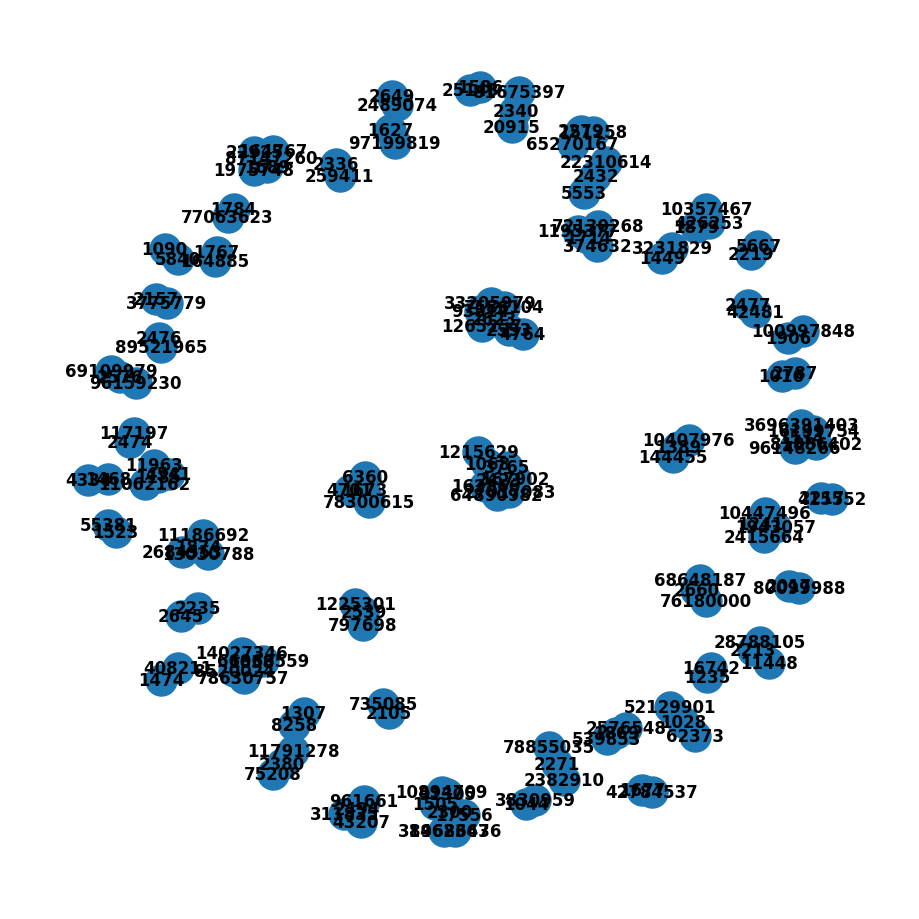

In [16]:
plot_undirected_graph(mygraph.edges)

In [20]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

job_postings_df = spark.read.csv("linkedin-job-trends/data/job_postings.csv", header=True, inferSchema=True)
salaries_df = spark.read.csv("linkedin-job-trends/data/salaries.csv", header=True, inferSchema=True)

data_df = job_postings_df.join(salaries_df, "job_id")

In [39]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, count, when

job_postings_df = spark.read.csv("linkedin-job-trends/data/job_postings.csv", header=True, inferSchema=True)
salaries_df = spark.read.csv("linkedin-job-trends/data/salaries.csv", header=True, inferSchema=True)

data_df = job_postings_df.join(salaries_df, "job_id")

# Rename 'salary' to 'label' after joining
data_df = data_df.withColumnRenamed("med_salary", "label")

# Drop rows with null values in the label column before splitting
data_df = data_df.filter(col("label").isNotNull()).cache()

categorical_cols = ["formatted_work_type", "application_type", "formatted_experience_level", "work_type"] # Removed 'location'
indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep") for c in categorical_cols]

numeric_cols = [f.name for f in data_df.schema.fields if str(f.dataType) in ('IntegerType', 'DoubleType', 'LongType') and f.name != 'label']

# Ensure the assembler uses only indexed categorical and numeric columns
assembler_input_cols = [f"{c}_idx" for c in categorical_cols] + numeric_cols

assembler = VectorAssembler(inputCols=assembler_input_cols, outputCol="features")


pipeline = Pipeline(stages=indexers + [assembler])
model_input_df = pipeline.fit(data_df).transform(data_df).select("label", "features")

# Verify that nulls have been removed from the 'label' column
null_count_after_filter = model_input_df.select(count(when(col("label").isNull(), "label"))).collect()[0][0]
print(f"Number of nulls in 'label' column after filtering: {null_count_after_filter}")

train_df, test_df = model_input_df.randomSplit([0.7, 0.3])

Number of nulls in 'label' column after filtering: 0


In [40]:
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col

# Initialize models with correct input/output columns
lr = LinearRegression(featuresCol="features", labelCol="label")
dt = DecisionTreeRegressor(featuresCol="features", labelCol="label")
rf = RandomForestRegressor(featuresCol="features", labelCol="label")

# Train the models
lr_model = lr.fit(train_df)
dt_model = dt.fit(train_df)
rf_model = rf.fit(train_df)

# Make predictions
lr_predictions = lr_model.transform(test_df)
dt_predictions = dt_model.transform(test_df)
rf_predictions = rf_model.transform(test_df)

# Evaluate the models using RMSE
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

lr_rmse = evaluator.evaluate(lr_predictions)
dt_rmse = evaluator.evaluate(dt_predictions)
rf_rmse = evaluator.evaluate(rf_predictions)

# Print RMSE values
print(f"Linear Regression RMSE: {lr_rmse}")
print(f"Decision Tree RMSE: {dt_rmse}")
print(f"Random Forest RMSE: {rf_rmse}")

# Determine and print the best model based on RMSE
best_model, best_rmse = min(
    [(lr_model, lr_rmse), (dt_model, dt_rmse), (rf_model, rf_rmse)],
    key=lambda x: x[1]
)
print(f"The best model is: {best_model.__class__.__name__} with a RMSE of: {best_rmse}")

Linear Regression RMSE: 53646.7740239593
Decision Tree RMSE: 43121.028805485446
Random Forest RMSE: 41670.63812063819
The best model is: RandomForestRegressionModel with a RMSE of: 41670.63812063819
